# Objective

My objectives with this notebook are:
- A brief Exploratory Data Analysis (EDA)
- Predictive Models for popularity
- Clustering visualization with insights for popularity and genres

The main results will be discuss at **Conclusions**

## Importing Libraries


In [103]:
# Python <stdio.h>
import warnings
import numpy as np
import pandas as pd
# Data Visualization
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Prediction
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
# Clustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Erase Warnings
warnings.filterwarnings("ignore")

## Preparing our dataset

In [104]:
# Import all the data
data = pd.read_csv('../input/top50spotify2019/top50.csv',encoding = "ISO-8859-1");
# Delete Extra column
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [105]:
# Define predictors set
x = data[['Beats.Per.Minute', 'Energy', 'Danceability', 'Loudness..dB..', 'Liveness', 'Valence.', 'Length.', 'Acousticness..', 'Speechiness.']]
# Define target variable
y = data[['Popularity']]
# Define info variables
info = data[['Track.Name', 'Artist.Name', 'Genre']]

# A brief Exploratory Data Analysis (EDA)

## Is there any collinearity in our features between each other or with popularity?
Let's find out using Spearman Correlation ranging from -1 to 1, where:
- *-1* Implies a strong negative correlation
- 0 Implies no correlation
- +1 Implies a strong positive correlation

In [106]:
# Spearman correlation calc
sc = pd.concat([x,y], axis=1).corr(method='spearman')

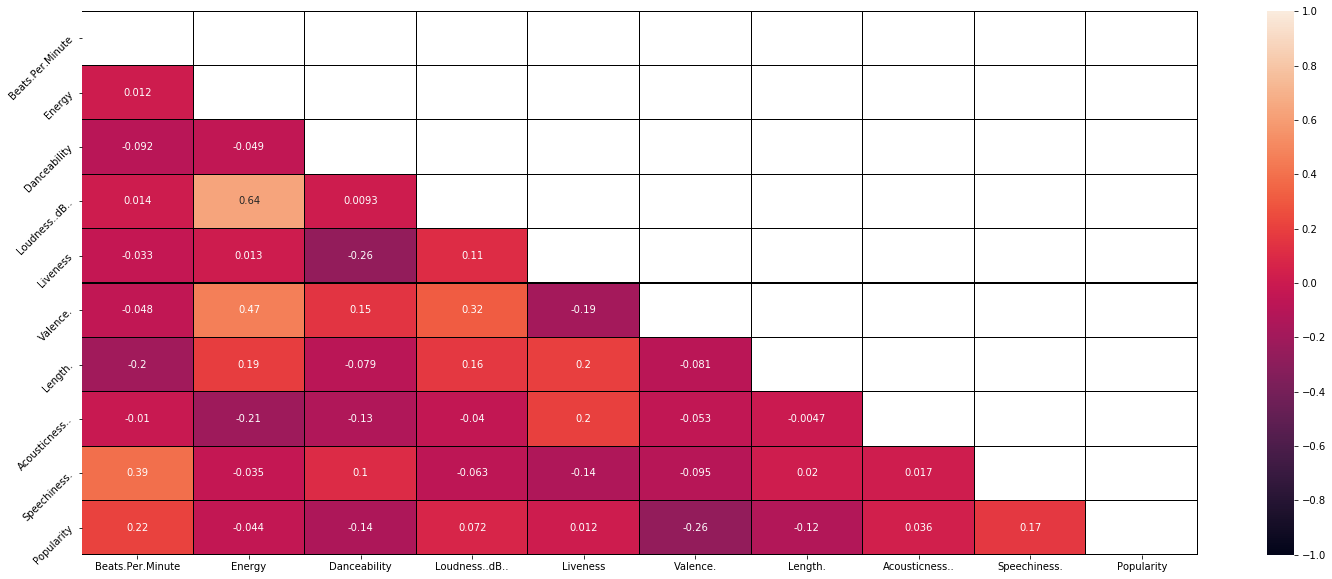

In [107]:
# Generate a mask for the upper triangle
triangle_mask = np.zeros_like(sc, dtype=np.bool)
triangle_mask[np.triu_indices_from(triangle_mask)] = True

# Plot
plt.figure(figsize = (25,10))
sns.heatmap(data = sc, linewidths=.1, linecolor='black', vmin = -1, vmax = 1, mask = triangle_mask, annot = True,
            cbar_kws={"ticks":[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]});
plt.yticks(rotation=45);

Only **Loudness** with **Energy** have a high positive correlation, but not that significant (most of the academic papers consider a correlation higher than *0.7* as significant). Because the lackness of strong monotonous correlations, I believe that the creation of linear predictive models becomes unnecessary.

## How many songs are located in each genre for Spotify Top 50?
For this, I will create a count plot with *seaborn*:

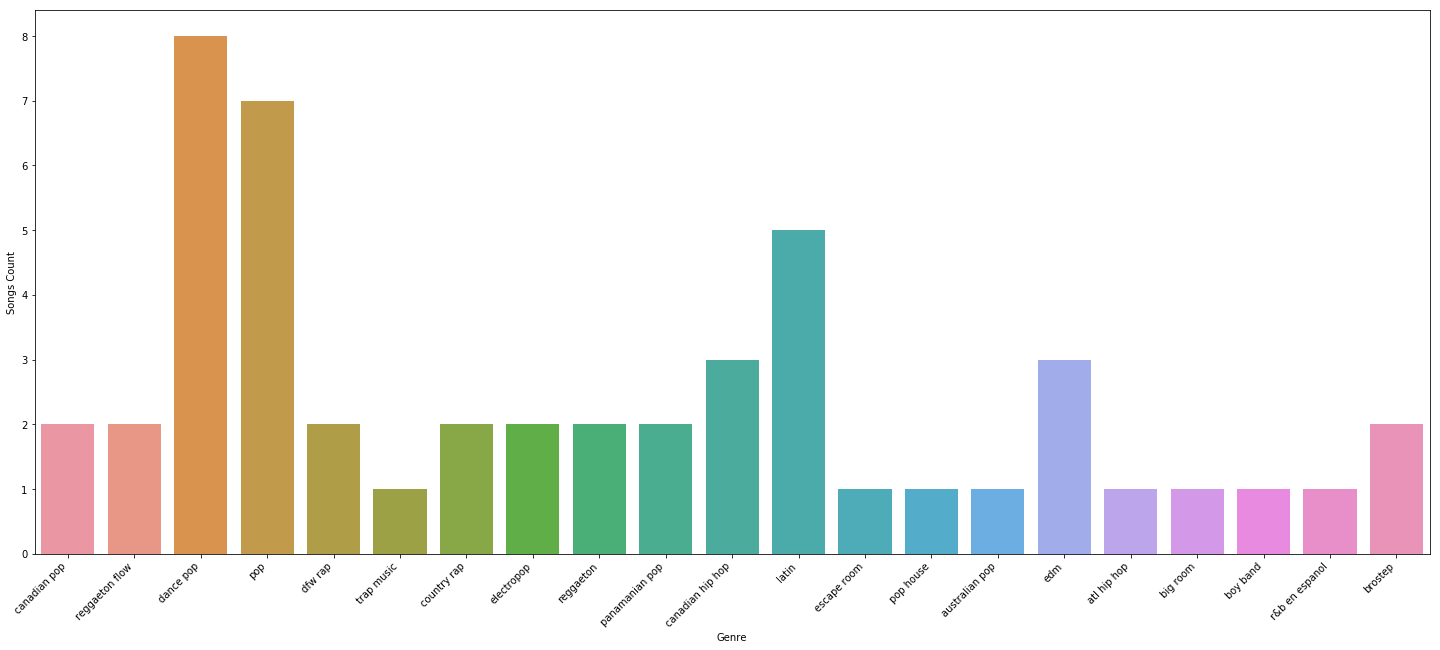

In [108]:
plt.figure(figsize = (25,10));
sns.countplot(x="Genre", data=info);
plt.ylabel('Songs Count');
plt.xticks(rotation=45, ha='right');

As we can see, **Pop** style in general contains most of 50 Top Songs. Because we have a small dataset and a lot of Genres I will simplify future genre analysis by creating a new *Genre* column, joining close styles into big groups:
- Pop: canadian pop, dance pop, pop, panamanian pop, australian pop and boy band
- Rap: dfw rap and country rap
- Reggaeton: reggaeton flow and reggaeton
- Hip hop: canadian hip hop and atl hip hop
- Eletronic: trap music,pop house, edm, big room, electropop and brostep
- Latin: latin and r&b en espanol
- Escape room: escape room

**PS**: I did know, but there is a discussion related to Escape Room genre that was created by Spotify algorithm (AWESOME). 

To do that, I will create this column manually:

In [109]:
for i in range(0,len(info)):
    if info.loc[i,'Genre'] in ['canadian pop','dance pop','pop','panamanian pop','australian pop','boy band']:
        info.loc[i,'Genre2'] = 'Pop'
    elif info.loc[i,'Genre'] in ['dfw rap','country rap']:
        info.loc[i,'Genre2'] = 'Rap'
    elif info.loc[i,'Genre'] in ['reggaeton flow','reggaeton']:
        info.loc[i,'Genre2'] = 'Reggaeton'
    elif info.loc[i,'Genre'] in ['canadian hip hop','atl hip hop']:
        info.loc[i,'Genre2'] = 'Hip hop'
    elif info.loc[i,'Genre'] in ['trap music','pop house','edm','big room','electropop','brostep']:
        info.loc[i,'Genre2'] = 'Eletronic'    
    elif info.loc[i,'Genre'] in ['latin','r&b en espanol']:
        info.loc[i,'Genre2'] = 'Latin'
    elif info.loc[i,'Genre'] in ['escape room']:
        info.loc[i,'Genre2'] = 'Escape room'        

Now, the same plot will be create

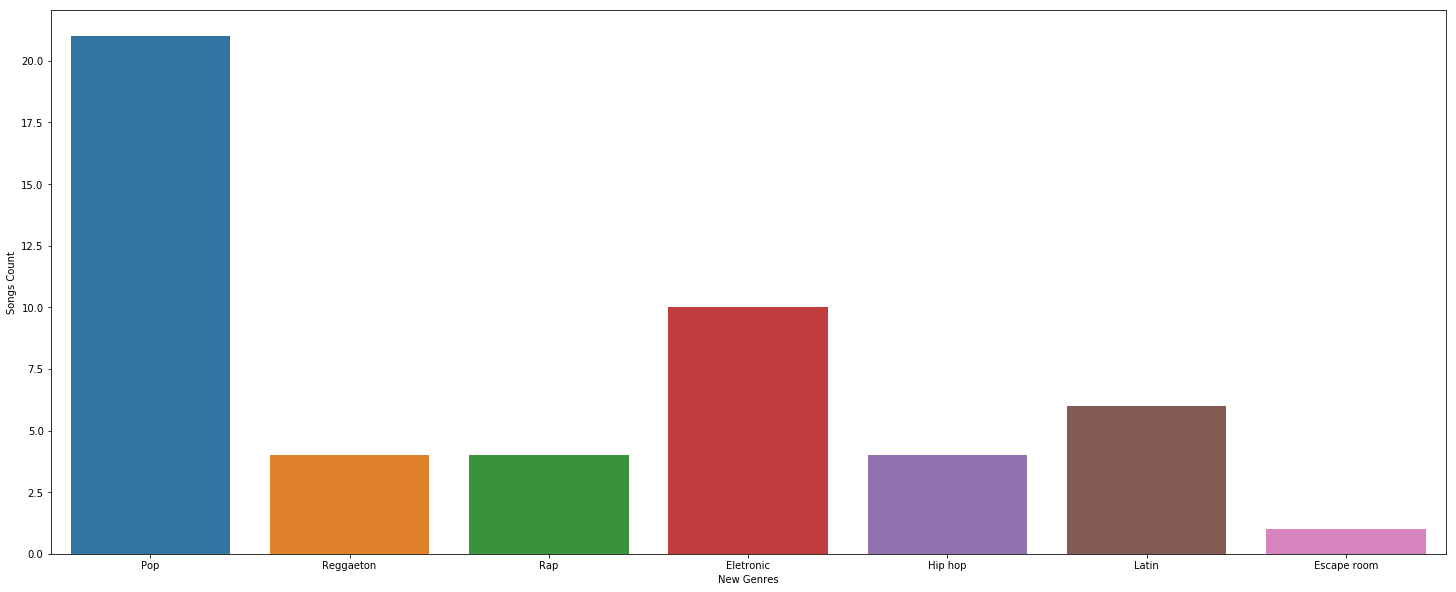

In [110]:
plt.figure(figsize = (25,10));
sns.countplot(x="Genre2", data=info);
plt.ylabel('Songs Count');
plt.xlabel('New Genres');

Now it is possible to see more clear that Pop Genres dominates this dataset follow by Eletronic and Latin styles.

## How is distributed average popularity over the genres?
Let's find out using again *seaborn* in our new column:

In [112]:
# Create aux dataframe for plot
df = pd.concat([info,y],axis=1)

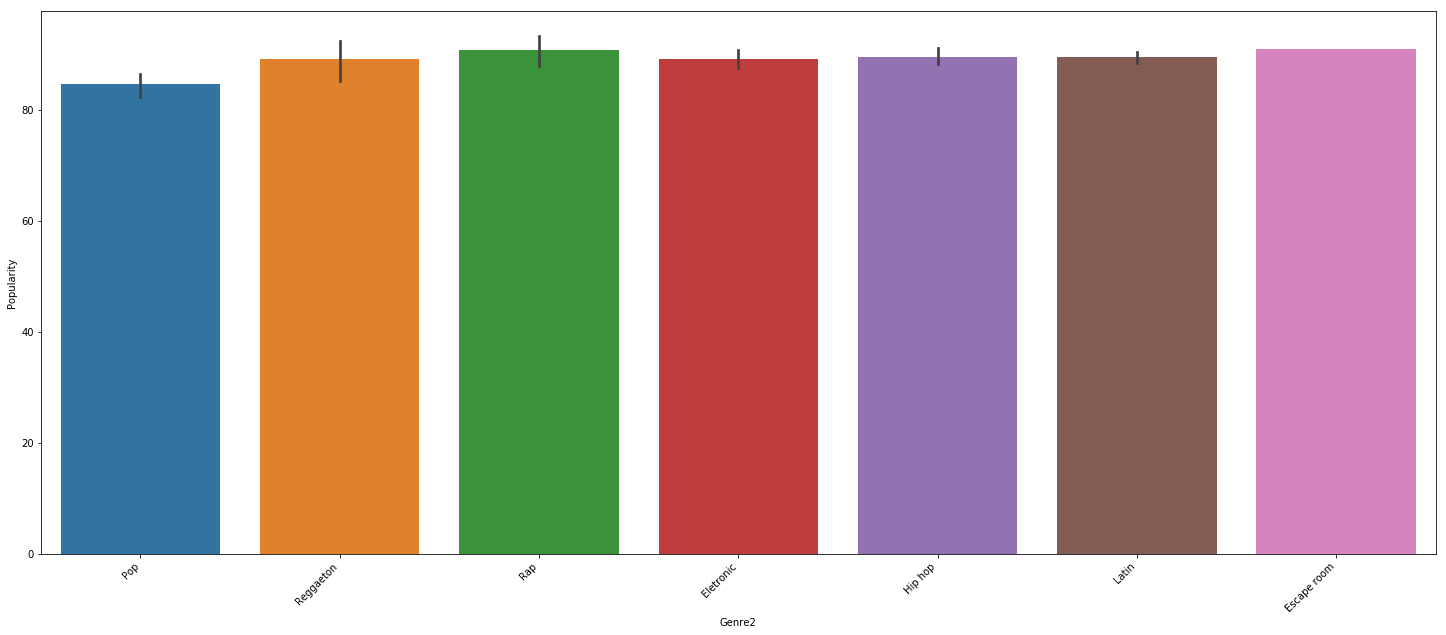

In [113]:
# Plot
plt.figure(figsize = (25,10));
sns.barplot(data=df,x='Genre2',y='Popularity');
plt.xticks(rotation=45, ha='right');

Based on this graph, we can take some infos:
- Even with most of the songs, **Pop** shows the lowest popularity average over all genres.
- Except for **Pop**, all average popularities are very close with **Rap** showing the higher

I will discuss more this result after the next plot using the original genre distribution

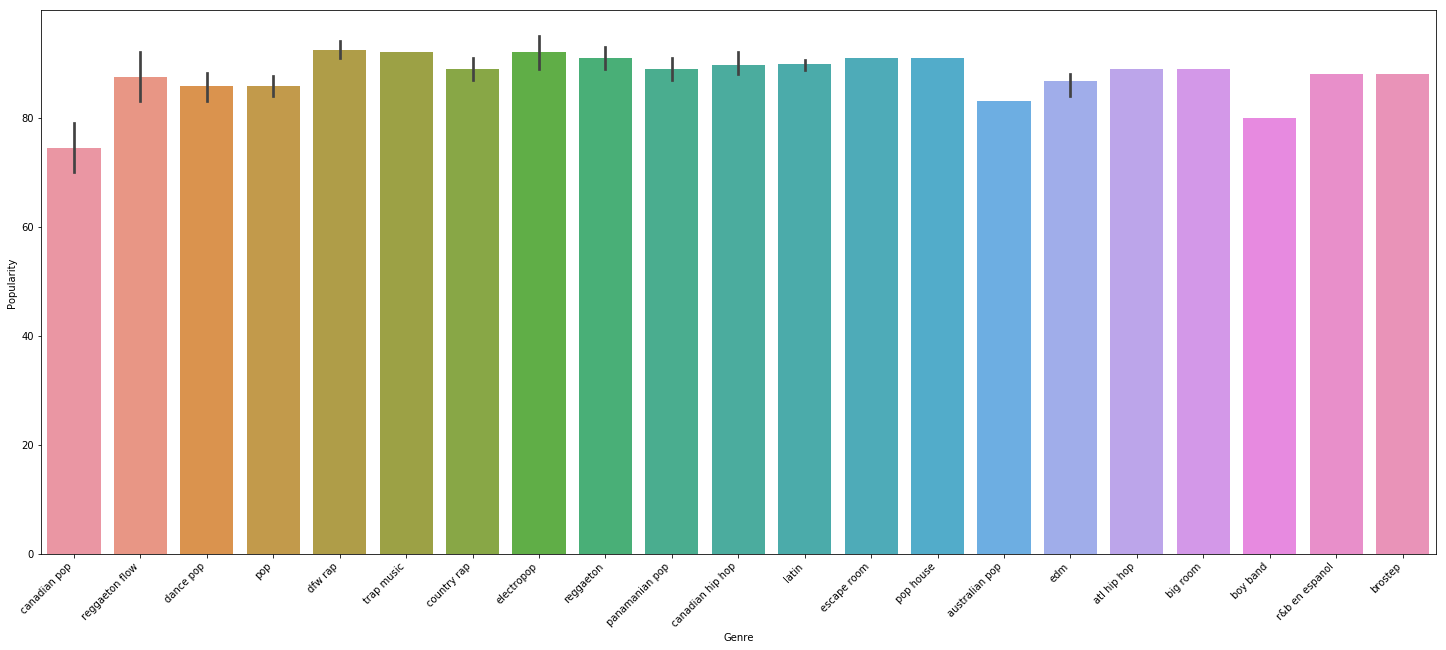

In [114]:
# Plot
plt.figure(figsize = (25,10));
sns.barplot(data=df,x='Genre',y='Popularity');
plt.xticks(rotation=45, ha='right');

Considering the previous two graphs, I believe that the low average popularity of the Pop genre shown in the first one is due to the fact that the *average metric* penalizes low values and some of the smaller genres pertaining to it such as australian pop, canadian pop and boy band have the lowest values of popularity (presented in the last plot) thus lowering the final average.
Also, as the other genres created have much less music, they end up benefiting (with less music, less chances to have a low popularity song).

# Predictive Analysis

Is it possible to predict **Popularity** based on X features?

Given the small dataset, I will implement a Cross-Validation 10 Folds using *sklearn* for our models creation. The predictive models chosen are:
- SVM (Support Vector Machine)
- RF (Random Forest)
- KNN (K Nearest Neighbours)

Because of correlation analysis in EDA, I will not create any Linear model as explained before.

The model developments has the follow pipeline:
- Apply CV 10 Folds in our data
- Standardize our train set and then our test set based on previous transformation
- Fit our models with defaults hyperparameters
- Predict with our models and get the MSE metric

The model chosen will be the one with the best average prediction metric (MSE) over the cross validation process.

## Model Development

In [46]:
# Defining some variables
metricsRFR = []       # Prediction Scores for Random Forest Regressor
metricsSVR = []       # Prediction Scores for Support Vector Regressor
metricsKNR = []       # Prediction Scores for K Nearest Neighbours Regressor

# Preprocessing init
ss = StandardScaler()

# Models init
svr = SVR()
rfr = RandomForestRegressor()
knr = KNeighborsRegressor(n_neighbors=3)

# Cross-Validation 10 Fold
cv = KFold(n_splits=10, random_state=1206, shuffle=True)

# Loop into all 10 Folds
for train_index, test_index in cv.split(x):
    # Define train and test to simplify our life
    x_train, x_test, y_train, y_test = x.loc[train_index,:], x.loc[test_index,:], y.loc[train_index,:], y.loc[test_index,:]
    # Fit and Transform our train set using StandardScaler
    x_train = ss.fit_transform(x_train)
    # Transform our test set based on x_train
    x_test = ss.transform(x_test)
    # Fit Models
    rfr.fit(x_train, y_train)
    svr.fit(x_train, y_train)
    knr.fit(x_train, y_train)
    # Predict using our models
    y_pred_rfr = rfr.predict(x_test)
    y_pred_svr = svr.predict(x_test)
    y_pred_knr = knr.predict(x_test)
    # Calculate and append Prediction Mean Square Error
    metricsRFR.append(mean_squared_error(y_test.values.ravel(), y_pred_rfr))
    metricsSVR.append(mean_squared_error(y_test.values.ravel(), y_pred_svr))
    metricsKNR.append(mean_squared_error(y_test.values.ravel(), y_pred_knr))

# Print the results
print('RFR had Averaged MSE: %.2f\nSVR had Averaged MSE: %.2f\nKNR had Averaged MSE: %.2f'
      % (np.mean(metricsRFR), np.mean(metricsSVR), np.mean(metricsKNR)))

RFR had Averaged MSE: 28.66
SVR had Averaged MSE: 19.51
KNR had Averaged MSE: 26.81


Based on those MSE results, I did not succeed to get an useful model using the *default* parameters and all features to predict Popularity in Spotify. Now I will try other approach: apply a simple feature selection before our models creation. I will do this **because given the small dataset (50 samples), would be preferred to have less variables to reduce our complexity**. For this, I will repeate the above code and apply some changes trying to see our models performance with 3,4 and 5 features.

## Model Development with Feature Selection

In [47]:
# Defining some variables
metricsRFR = []       # Prediction Scores for Random Forest Regressor
metricsSVR = []       # Prediction Scores for Support Vector Regressor
metricsKNR = []       # Prediction Scores for K Nearest Neighbours Regressor
rfrMSE = []           # Aux variable to keep MSE track for 3,4 and 5 features in Random Forest Regressor
svrMSE = []           # Aux variable to keep MSE track for 3,4 and 5 features in Support Vector Regressor
knrMSE = []           # Aux variable to keep MSE track for 3,4 and 5 features in K Nearest Neighbours Regressor
# Preprocessing init
ss = StandardScaler()

# Models init
svr = SVR()
rfr = RandomForestRegressor()
knr = KNeighborsRegressor(n_neighbors=3)

# Cross-Validation 10 Fold
cv = KFold(n_splits=10, random_state=1206, shuffle=True)

# Loop into all 10 Folds
for train_index, test_index in cv.split(x):
    # Define train and test to simplify our life
    x_train, x_test, y_train, y_test = x.loc[train_index,:], x.loc[test_index,:], y.loc[train_index,:], y.loc[test_index,:]
    # Fit and Transform our train set using StandardScaler
    x_train = ss.fit_transform(x_train)
    # Transform our test set based on x_train
    x_test = ss.transform(x_test)
    # Apply Feature Selection to use only 3,4 or 5 features
    for nFeat in [3,4,5]:
        # Init FS object to nFeat predictors variables
        fs = SelectKBest(score_func=mutual_info_regression, k=nFeat)
        # Choose our selected features in train/test set
        x_train_fs = fs.fit_transform(x_train, y_train.values.ravel())
        x_test_fs = fs.transform(x_test)
        # Fit Models
        rfr.fit(x_train_fs, y_train.values.ravel())
        svr.fit(x_train_fs, y_train.values.ravel())
        knr.fit(x_train_fs, y_train.values.ravel())
        # Predict using our models
        y_pred_rfr = rfr.predict(x_test_fs)
        y_pred_svr = svr.predict(x_test_fs)
        y_pred_knr = knr.predict(x_test_fs)
        # Save MSE
        rfrMSE.append(mean_squared_error(y_true=y_test.values.ravel(), y_pred=y_pred_rfr))
        svrMSE.append(mean_squared_error(y_true=y_test.values.ravel(), y_pred=y_pred_svr))
        knrMSE.append(mean_squared_error(y_true=y_test.values.ravel(), y_pred=y_pred_knr))

    # Append Prediction Mean Square Error
    metricsRFR.append(rfrMSE)
    metricsSVR.append(svrMSE)
    metricsKNR.append(knrMSE)
    # Reset our MSE lists
    rfrMSE = []
    svrMSE = []
    knrMSE = []

In [48]:
# Calculate AVG MSE for each selected group feature in each model
avgRFR = np.mean(metricsRFR, axis=0)
avgSVR = np.mean(metricsSVR, axis=0)
avgKNR = np.mean(metricsKNR, axis=0)
# Print results
print('--- AVG MSE for Random Forest Regressor')
print('3 Features: %.2f\n4 Features: %.2f\n5 Features: %.2f\n' % (avgRFR[0], avgRFR[1], avgRFR[2]))
print('--- AVG MSE for Support Vector Regressor')
print('3 Features: %.2f\n4 Features: %.2f\n5 Features: %.2f\n' % (avgSVR[0], avgSVR[1], avgSVR[2]))
print('--- AVG MSE for K Nearest Regressor')
print('3 Features: %.2f\n4 Features: %.2f\n5 Features: %.2f\n' % (avgKNR[0], avgKNR[1], avgKNR[2]))

--- AVG MSE for Random Forest Regressor
3 Features: 28.56
4 Features: 30.43
5 Features: 22.70

--- AVG MSE for Support Vector Regressor
3 Features: 22.11
4 Features: 21.66
5 Features: 21.44

--- AVG MSE for K Nearest Regressor
3 Features: 39.43
4 Features: 29.81
5 Features: 25.17



Based on those results, our models did not improved at all using less variables after a feature selection (A good MSE is close to zero). I will discuss in **Conclusions** possibles reasons for this.

# Clustering Analysis
Is it possible to clusterize our data using those 9 numeric features and get info about *genre* and *popularity*? Let's find out using PCA with KNN and tSNE. 

## Principal Components Analysis with K Means in a 2D plot
The pipeline for this:
- Create a PCA for 2 components (2D plot)
- Analyze explained ratio
- Create a K Means using silhouette analysis to find optimal K in a range from 2 to N clusters, where N means the maximum number of genres in our dataset
- Analyze the results (using genre categorical column and popularity numerical column)

### Scale our features before any PCA analysis

In [49]:
# Scale our x data
ss = StandardScaler()
# Fit and transform our data using StandardScaler
x_ss = ss.fit_transform(x)

### Model Development - PCA with 2 components

In [50]:
# Create a PC space with 2 components only
pca = PCA(n_components=2)
# Fit and Transform X to PC dimension
pc = pca.fit_transform(x_ss)

In [51]:
# Print Explained Variance Ratio
print('PC1 explained %.2f ratio and PC2 explained %.2f ratio of total variance.' %
      (pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]))

PC1 has explained 0.25 ratio and PC2 has explained 0.18 ratio of total variance.


So, summing up our explained variance ratio using 2 components we got **43%** of explanation.

### Model Development - KMeans in 2D

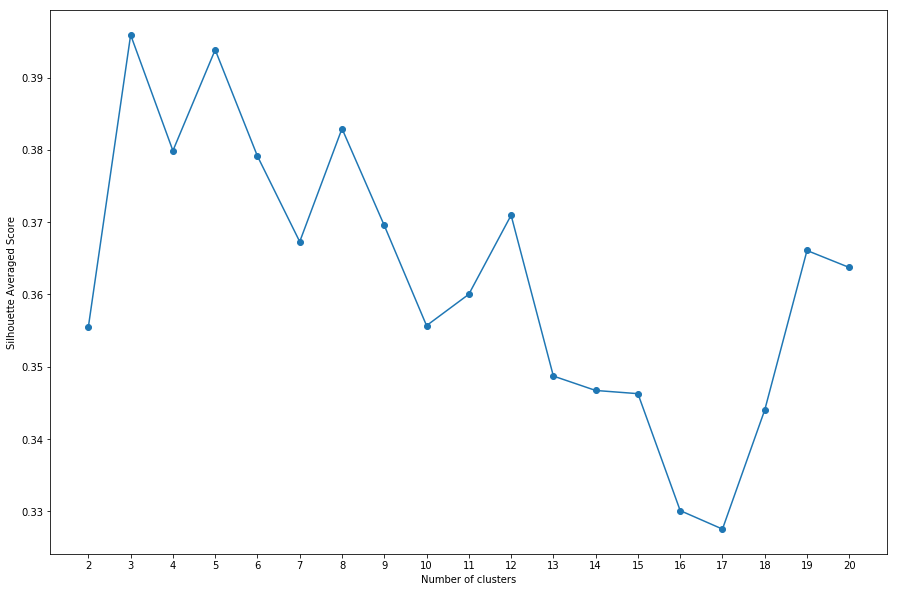

In [52]:
# Define our range of clusters based on genre size
n_clusters = range(2, len(info.Genre.unique())) 
# Create a list to append silhouette_avg values for each K to plot
silhouette_avg = []

# Loop to find optimal K
for K in n_clusters:
    # Create KNN model
    km = KMeans(n_clusters=K, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=1206)
    # Fit and predict with K clusters using Principal Components
    pred = km.fit_predict(pc)
    # Calculate silhouette score
    silhouette_avg.append(silhouette_score(pc, pred))

# Plot the results to define our optimal K
plt.figure(figsize=(15,10))
plt.plot(n_clusters, silhouette_avg, marker='o');
plt.xticks(n_clusters);
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Averaged Score');

### Understanding Silhouette Averaged Score
This is one of the methods that helps to choose an optimal K cluster and is under the range *-1 to +1* where near *+1* indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. That explanations was get from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

So, the optimal K that will be chosen is **K = 3** that has the higher metric.

### KMeans 2D Analysis

In [53]:
# Create our KMeans model using optimal K
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=1206)
# Fit and predict with 3 clusters using Principal Components
pred = km.fit_predict(pc)

In [54]:
# Create a Dataframe for PC with target var
df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2'])
# Create a column for our clusters (KMeans prediction)
df['Clusters']=pd.Series(pred)
# Join with target info/popularity dataset
df = pd.concat([df, y, info], axis = 1)
# A sample of our new dataframe
df.head(3)

,PC1,PC2,Clusters,Popularity,Track.Name,Artist.Name,Genre,Genre2
0,-0.154051,-0.310381,1,79,Señorita,Shawn Mendes,canadian pop,Pop
1,-2.084589,0.189137,1,92,China,Anuel AA,reggaeton flow,Reggaeton
2,0.001561,4.102778,0,85,boyfriend (with Social House),Ariana Grande,dance pop,Pop


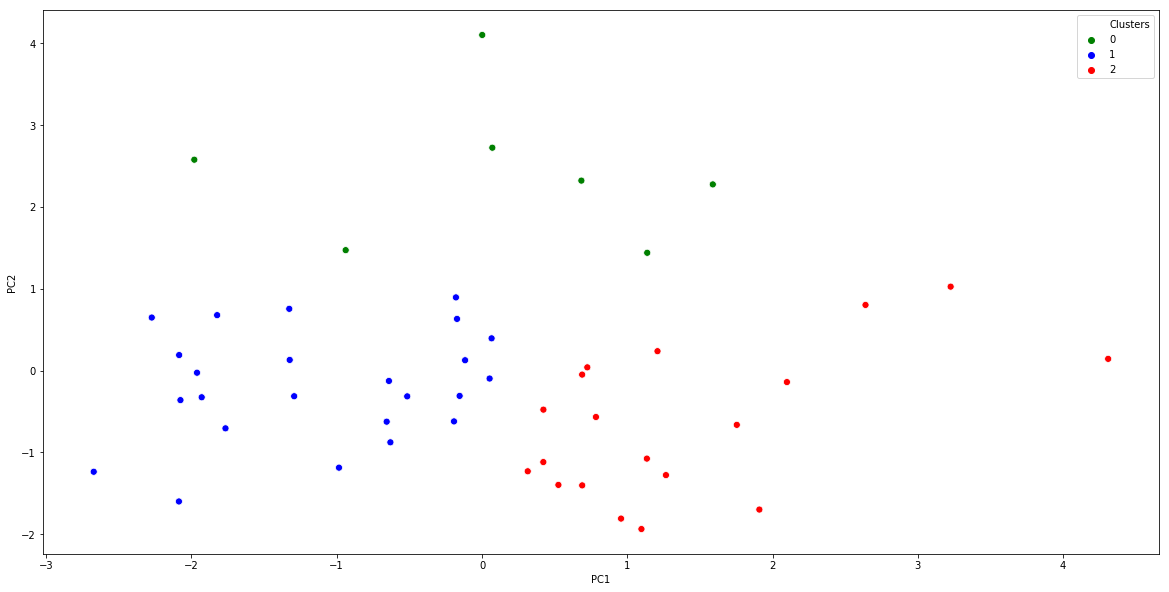

In [55]:
# Plot using seaborn our clusterization
plt.figure(figsize=(20,10));
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=df, palette=['green','blue','red'], s= 50);

Now, let's see the same plot side by side with other plot where the colors are define by the **Genre2** column:

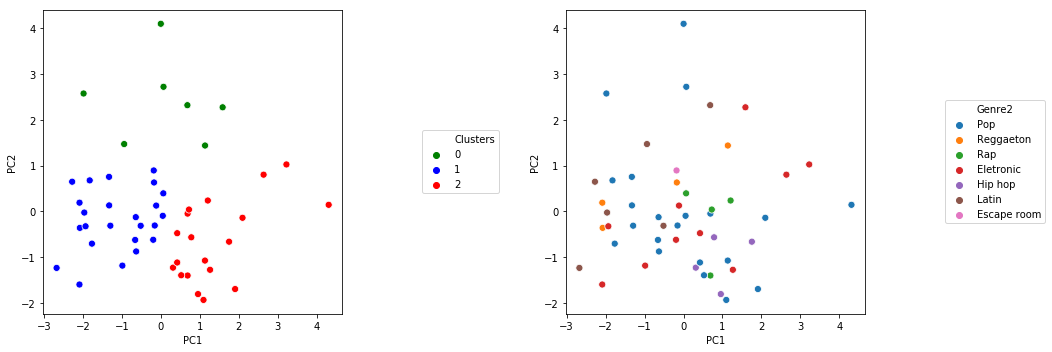

In [56]:
# Define subplots to get a side by side view
fig, ax = plt.subplots(1,2, figsize=(15,5));
# Plot KMeans 
p1 = sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=df, palette=['green','blue','red'],  ax=ax[0], s= 50);
# Put KMeans legend outside
p1.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1);
# Plot with genre colors 
p2 = sns.scatterplot(x="PC1", y="PC2", hue="Genre2", data=df, ax=ax[1], s=50);
# Put again legend outside
p2.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1);
# Insert a safe space between the plots
fig.tight_layout()

Based on this plot, there isn't **any clustering for defined genres**, because they are very mixed over the clusters.

Now, let's see one plot where a marker size is defined by **Popularity**:

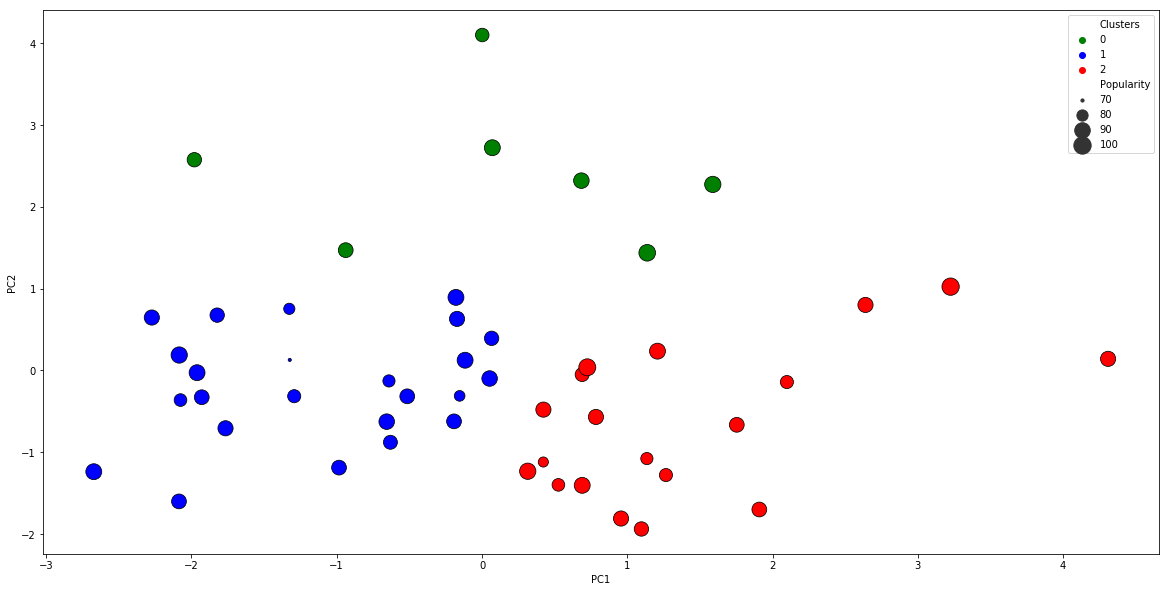

In [57]:
# Plot using seaborn our clusterization
plt.figure(figsize=(20,10));
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=df, palette=['green','blue','red'], size="Popularity", sizes=(10, 300), edgecolor="black");

Again popularity has not able to divide into different clusters, having mixed values.

Let's see if a 3D plot is able to verify a clusterization for **Genres** and **Popularity Size**.

## Principal Components Analysis with K Means in a 3D plot
The pipeline for this:
- Create a PCA for 3 components (3D plot)
- Analyze explained ratio and compare with PCA with 2 components
- Create a K Means using silhouette analysis to find optimal K in a range from 2 to N clusters, where N means the maximum number of genres in our dataset
- Analyze the results (using genre categorical column and popularity numerical column)

In [58]:
# Create a PC space with 2 components only
pca = PCA(n_components=3)
# Fit and Transform X to PC dimension
pc = pca.fit_transform(x_ss)

In [61]:
pca.explained_variance_ratio_

array([0.25020289, 0.17532301, 0.14144382])

In [62]:
# Print Explained Variance Ratio
print('PC1 explained %.2f\nPC2 explained %.2f\nPC3 explained %.2f\nFor total of %.2f Explained Variance Ratio.' %
      (pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1], pca.explained_variance_ratio_[2],sum(pca.explained_variance_ratio_)))

PC1 explained 0.25
PC2 explained 0.18
PC3 explained 0.14
For total of 0.57 Explained Variance Ratio.


Compared with 2 components that explained 43% now we have 57% that could be considerate a good improvement.

### Model Development - KMeans in 3D

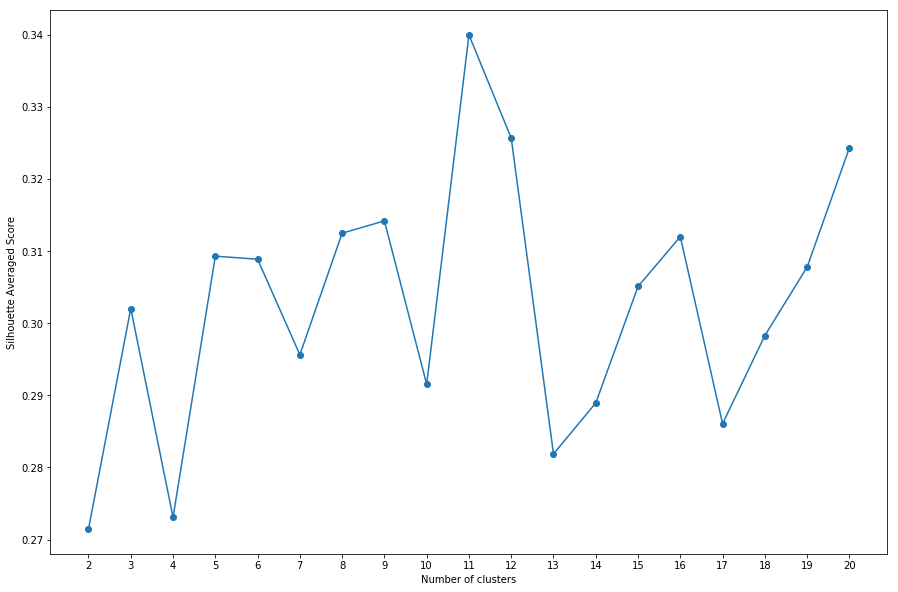

In [63]:
# Define our range of clusters based on genre size
n_clusters = range(2, len(info.Genre.unique())) 
# Create a list to append silhouette_avg values for each K to plot
silhouette_avg = []

# Loop to find optimal K
for K in n_clusters:
    # Create KNN model
    km = KMeans(n_clusters=K, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=1206)
    # Fit and predict with K clusters using Principal Components
    pred = km.fit_predict(pc)
    # Calculate silhouette score
    silhouette_avg.append(silhouette_score(pc, pred))

# Plot the results to define our optimal K
plt.figure(figsize=(15,10))
plt.plot(n_clusters, silhouette_avg, marker='o');
plt.xticks(n_clusters);
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Averaged Score');

Besides my optimism, using 3 components decreased the Silhouette Score maximum value and increase the clusters complexity. Let's see if this increase in number of clusters could give any information related to **Genre** or **Popularity**.

So, the optimal K that will be chosen is **K = 11** that has the higher metric.

### KMeans 3D Analysis

In [65]:
# Create our KMeans model using optimal K
km = KMeans(n_clusters=11, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=1206)
# Fit and predict with 3 clusters using Principal Components
pred = km.fit_predict(pc)

In [88]:
# Create a Dataframe for PC with targets
df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2','PC3'])
# Create a column for our clusters (KMeans prediction)
df['Clusters']=pd.Series(pred)
# Join with target info/popularity dataset
df = pd.concat([df, y, info], axis = 1)
# A sample of our new dataframe
df.head(3)

,PC1,PC2,PC3,Clusters,Popularity,Track.Name,Artist.Name,Genre,Genre2
0,-0.154051,-0.310381,-1.321848,5,79,Señorita,Shawn Mendes,canadian pop,Pop
1,-2.084589,0.189137,-0.134561,1,92,China,Anuel AA,reggaeton flow,Reggaeton
2,0.001561,4.102778,2.070848,3,85,boyfriend (with Social House),Ariana Grande,dance pop,Pop


In [89]:
# Plot 3D - KNN Clusters
px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Clusters')

In [90]:
# Plot 3D - Genres with Popularity size
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Clusters', size='Popularity', symbol='Genre2')
fig.update_layout(legend=dict(x=-.1, y=0.5))

With this plot, it is possible to see that PCA/KMeans approach was unsuccessful to clusterize and separate base on popularity and genre as genre is scattered in the plot. This result will be discussed in **Conclusions**.

## TSNE in a 2D Plot

To find a better result using TSNE, I will evaluate different values for **perplexity/learning rate** that are hyperparameters.

**PS**: For TSNE **I will not** use popularity size, given the fact that I realize the it's range doesn't show any major difference between the points as we saw previously in KNN plots.

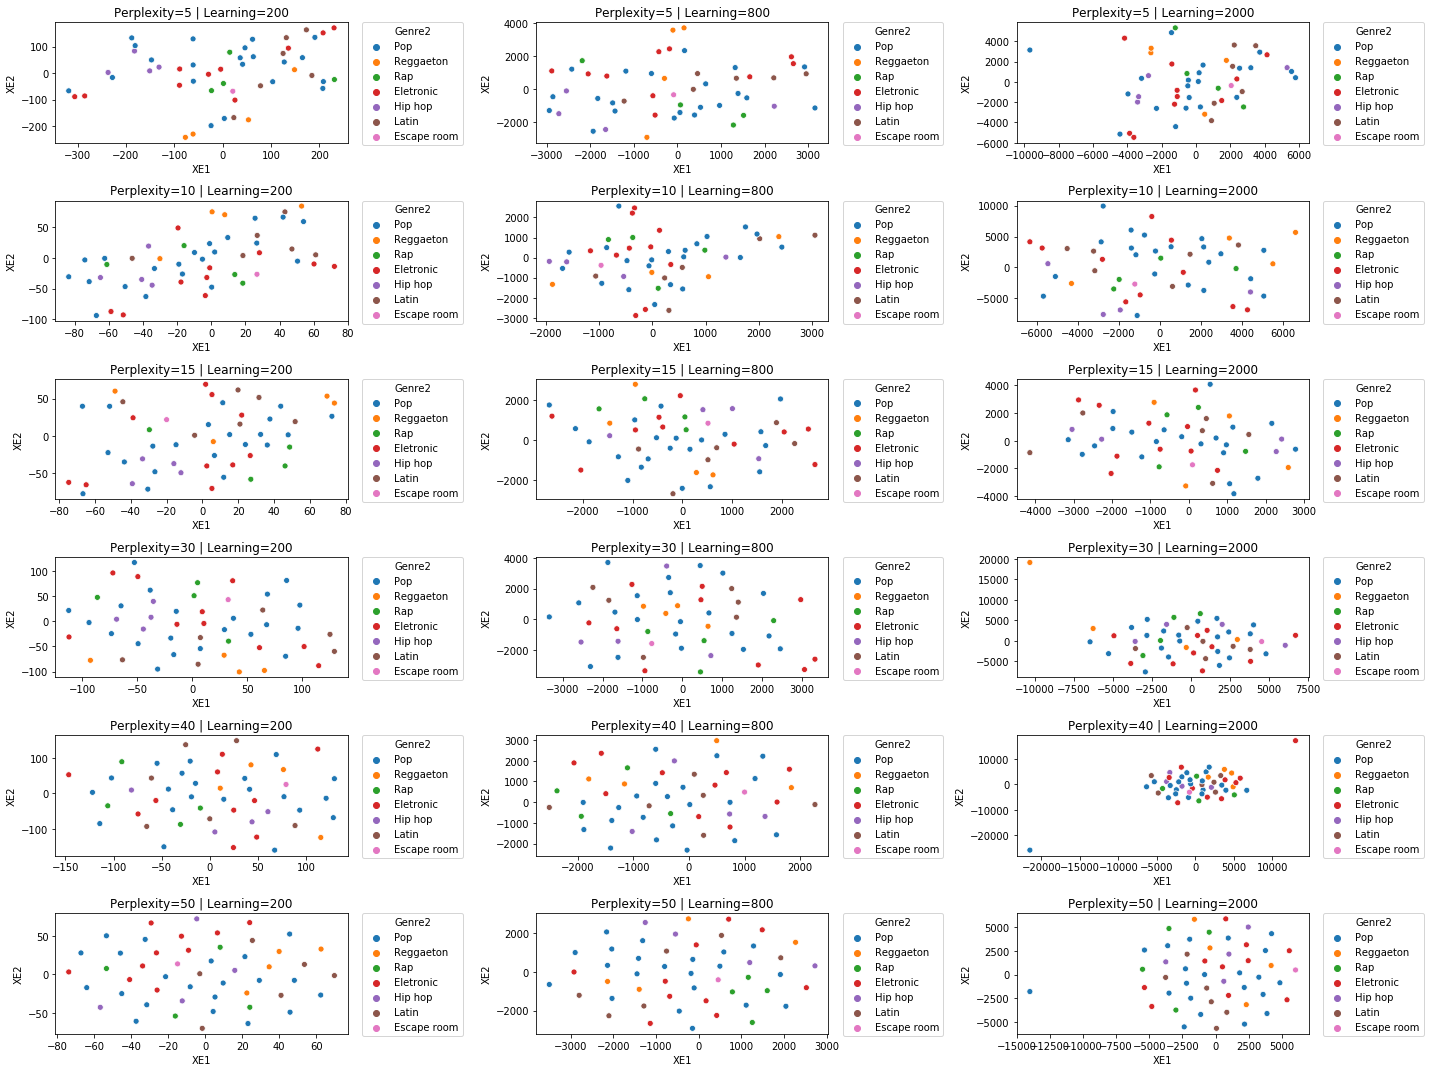

In [102]:
# Define ranges for TSNE hyperparameters
perplexities = [5,10,15,30,40,50]
learning = [200, 800, 2000]
# Create subplots 
fig, ax = plt.subplots(len(perplexities),len(learning), figsize=(20,15))

# Manual Grid Search for best hyper parameters through loop
for p in range(0,len(perplexities)):
    for l in range(0,len(learning)):
        # Create TSNE model
        tsne = TSNE(n_components=2, n_iter=2000, perplexity=perplexities[p], learning_rate=learning[l])
        # Fit and Transform with X scaled for PC
        x_emb = tsne.fit_transform(x_ss)
        # Turn X embeddeb into a dataframe to a easy plot
        x_emb = pd.DataFrame(data = x_emb, columns = ['XE1', 'XE2'])
        # Join with target categories
        x_emb = pd.concat([x_emb, info], axis = 1)
        # Plot 2D data
        sns.scatterplot(x='XE1', y='XE2', hue="Genre2", data=x_emb, ax=ax[p][l]);
        ax[p][l].set_title(("Perplexity=%d | Learning=%d" % (perplexities[p],learning[l])));
        ax[p][l].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Improve our layout
plt.tight_layout()

Unfortunately, TSNE could not separate our feature in clusters and get info about Genre. Given that, I will do an analysis about the results found here in **Conclusions**. 

# Conclusions
- Popularity data does not present any major difference between the samples, showing a short variance range and therefore indifferent (EDA presents that proof). This could be responsable for the fact that this target variable did not help in Prediction/Clustering Analysis.
    + **In Prediction, our models failed to get a good MSE even after a feature selection because our target variable did not change at all.**
    + **In Clustering, as we could see in KMeans plot Popularity size was practically the same for most of the samples.**
- However, as the database refers to spotify's top 50, it was expected that popularity would not change as much.
- Probably, this dataset is too small (only 50 samples) to get the desired answers for my questions (predict Songs popularity using those attributes and get clusters from those features to findo info about Song genres). I believe that this same analysis using a large dataset could have much better results.
- I understand that using default hyperparameters in Prediction Analysis I could improve my results, but based in previous statements I don't think that would change at all my results. That was the reason for me to not try a TSNE 3D.
